In [1]:
import copy

In [2]:
import datetime

In [3]:
import pprint
from pathlib import Path

import cartopy

In [4]:
import geopandas as gpd
import pytz
import rasterio

In [5]:
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

In [6]:
from pyproj import CRS, Transformer

import a301_lib  # noqa

pacific = pytz.timezone("US/Pacific")
date = datetime.datetime.today().astimezone(pacific)
print(f"written on {date}")

******************************
context imported. Front of path:
/home/phil/work

written on 2020-11-18 07:50:10.310651-08:00


(vancouver_hires)=
# Adding a high resolution map

Below we read band 5 from the small Vancouver image we wrote out in the {ref}`rasterio_3bands` notebook, and put it on a map with a UTM-10N crs.  We then add a high resolution coastline read from the openstreetmap coastline database.  I use geopandas to inspect the shapefile that
holds the streetmap coastline shapes.

## Read the geotiff with rasterio

I'm going to map Band 5, which is layer 3 in the tiff file.

/home/phil/repos/a301_2020/notebooks


Text(0.5, 1.0, 'band 5 reflectance for Vancouver section')

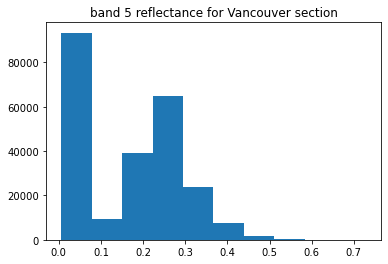

In [7]:
notebook_dir = Path().resolve().parent
print(notebook_dir)
week10_scene = notebook_dir / "week10/vancouver_345_refl.tiff"
with rasterio.open(week10_scene) as raster:
    affine_transform = raster.transform
    crs = raster.crs
    profile = raster.profile
    refl = raster.read(3)
plt.hist(refl.flat)
plt.title("band 5 reflectance for Vancouver section")

In [8]:
print(f"profile: \n{pprint.pformat(profile)}")

profile: 
{'count': 3,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float64',
 'height': 600,
 'interleave': 'pixel',
 'nodata': -9999.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 479085.0,
       0.0, -30.0, 5471475.0),
 'width': 400}


## Locate UBC on the map

We need to project the center of campus from lon/lat to UTM 10N x,y using pyproj.Transformer.transform
https://pyproj4.github.io/pyproj/stable/examples.html?highlight=transform

I create a geodetic lat/lon transform (`p_latlon`) so a I can
move from the UTM10 crs to lat/lon and back.

In [9]:
p_utm = crs
print(f"\nutm projection:\n\n{p_utm.to_wkt()}")
p_latlon = CRS.from_proj4("+proj=latlon")
print(f"\ngeodetic (latlon) projection: \n\n{p_latlon.to_wkt()}\n")
transform = Transformer.from_crs(p_latlon, p_utm)
ubc_lon = -123.2460
ubc_lat = 49.2606
ubc_x, ubc_y = transform.transform(ubc_lon, ubc_lat)
height, width = refl.shape
ubc_ul_xy = affine_transform * (0, 0)
ubc_lr_xy = affine_transform * (width, height)
print(f"here are the ul and lr corners: \n" f"{ubc_ul_xy=}, {ubc_lr_xy=}")


utm projection:

PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]

geodetic (latlon) projection: 

GEOGCRS["unknown",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ID["EPSG",6326]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8901]],CS[ellipsoidal,2],AXIS["longitude",east,ORDER[1],ANGLEUNIT["degree",0.0174532925199433,ID["EPSG",9122]]],AXIS["latitude",north,ORDER[2],AN

## Higher resolution coastline

Here is what Point Grey looks like with the [open street maps](https://automating-gis-processes.github.io/site/notebooks/L6/retrieve_osm_data.html) coastline database.

Optional: If you have a coastline on your own image you can make your own coastlines database.  There is a good article about different sources for map data on the blog [python4oceanographers](
https://ocefpaf.github.io/python4oceanographers/blog/2015/06/22/osm/).  The basic steps I used:

1. I download the 1 GByte (uncommpressed) zip file of WGS84 coastline database from [openstreetmap](https://osmdata.openstreetmap.de/data/coastlines.html)

2. It is now in a301_lib.data_share/openstreetmap in the folder
   coastlines-split-4326  (4326 is the epsg number for WGS84 lon/lat)

3. Figure out the lon/lat coordinates of a bounding box that contains your scene

4. Get a fiona prompt, which provides the command line program ogr2ogr
   (ogr stands for"OpenGIS Simple Features Reference Implementation"). Just as rasterio has `rio insp`
   to look at metadata, etc., fiona as `fio insp`.  To use it, open a terminal and point fiona
   at coastlines-split-4326 by typing

       fio insp coastlines-split-4326

   in the directory where you unzipped the folder.  With fio you can for example, check the crs with
   `src.crs` as demoed in class.

5. Quit fio with `ctrl-D` and get back to a regular bash prompt.  You can create a new shapefile
   given your bounding box using `ogr2ogr` to filter all lines not in the box.
   For Vancouver, I used this command at the prompt (all one line, lons are negative,
   lats are positive).  Substitute your own lons and lats (note all - signs are single, not double hyphens)

       cd /home/jovyan/work/data_share/openstreetmap
       ls *
       ogr2ogr -skipfailures -f "ESRI Shapefile"  -clipsrc -123.5 49 -123.1 49.4   /home/jovyan/work/ubc_coastlines coastlines-split-4326

   this extracts the segments and writes them to a new  folder called ubc_coastlines in your work directory which is less than 284 Kbytes and which provides the coastlines below.

## Mapped image with no coastline

Sanity check to make sure we've got the right image.  I set the

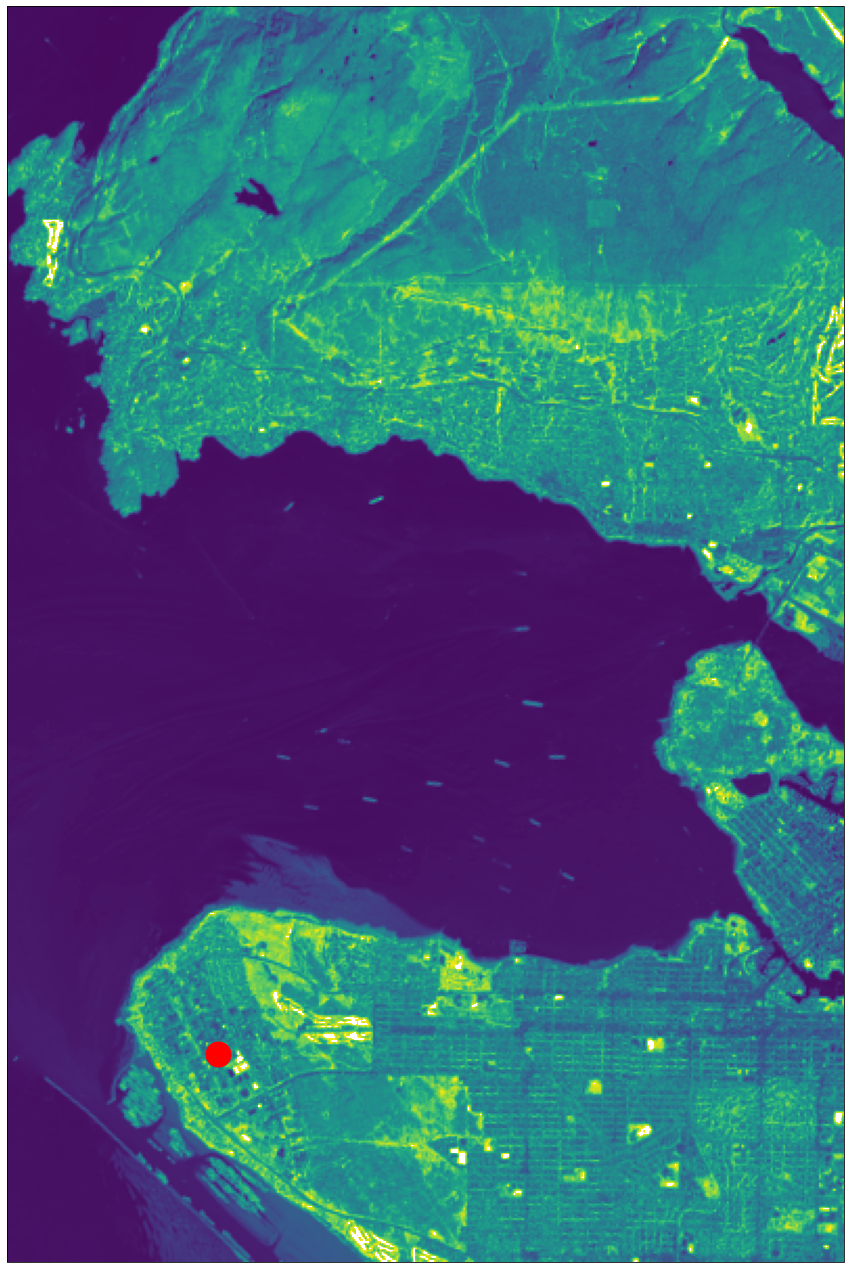

In [10]:
vmin = 0.0
vmax = 0.5
the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)
palette = "viridis"
pal = copy.copy(plt.get_cmap(palette))
pal.set_bad("0.75")  # 75% grey for out-of-map cells
pal.set_over("w")  # color cells > vmax red
pal.set_under("k")  # color cells < vmin black
#
# cartopy needs it's own flavor of the crs
#
cartopy_crs = cartopy.crs.epsg(crs.to_epsg())
fig, ax = plt.subplots(1, 1, figsize=[15, 25], subplot_kw={"projection": cartopy_crs})
image_extent = [ubc_ul_xy[0], ubc_lr_xy[0], ubc_lr_xy[1], ubc_ul_xy[1]]
ax.imshow(
    refl,
    origin="upper",
    extent=image_extent,
    transform=cartopy_crs,
    cmap=pal,
    norm=the_norm,
)
ax.plot(ubc_x, ubc_y, "ro", markersize=25)
ax.set_extent(image_extent, crs=cartopy_crs)

## Read the shape file and add the coastline to the image

Note that PlateCarree is another name for WGS84 datum, simple lat/lon which is the projection of the coastlines-split-4326 shapefile.

https://desktop.arcgis.com/en/arcmap/10.3/guide-books/map-projections/plate-carr-e.htm

The cell below reads the coastlines into a geopandas dataframe.  The
part we want is the column called "geometry" which lists the linestring
objects that form the coastline.  Here is the first row:

In [11]:
coastline_dir = a301_lib.data_share / "openstreetmap/ubc_coastlines"
df_coast = gpd.read_file(coastline_dir)
print(len(df_coast))
print(df_coast.head())
print(df_coast.crs)
df_coast["geometry"]

62
     FID                                           geometry
0  34610  LINESTRING (-123.30719 49.33912, -123.30728 49...
1  34611  LINESTRING (-123.27536 49.34069, -123.27548 49...
2  34614  LINESTRING (-123.27309 49.34128, -123.27316 49...
3  34616  LINESTRING (-123.27892 49.35420, -123.27932 49...
4  34808  LINESTRING (-123.19657 49.11045, -123.19677 49...
epsg:4326


0     LINESTRING (-123.30719 49.33912, -123.30728 49...
1     LINESTRING (-123.27536 49.34069, -123.27548 49...
2     LINESTRING (-123.27309 49.34128, -123.27316 49...
3     LINESTRING (-123.27892 49.35420, -123.27932 49...
4     LINESTRING (-123.19657 49.11045, -123.19677 49...
                            ...                        
57    LINESTRING (-123.35510 49.34087, -123.35504 49...
58    LINESTRING (-123.34203 49.34945, -123.34194 49...
59    LINESTRING (-123.33500 49.35759, -123.33493 49...
60    LINESTRING (-123.33491 49.35777, -123.33488 49...
61    LINESTRING (-123.29119 49.36339, -123.29120 49...
Name: geometry, Length: 62, dtype: geometry

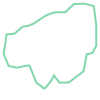

In [12]:
df_coast.iloc[0].geometry

## Make the map

To put on thecoastlines, I just add all the shapes to the axis

/home/phil/mini38/envs/work/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:761: UserWarning: Approximating coordinate system <cartopy._crs.Geodetic object at 0x7f64109b0400> with the PlateCarree projection.
  warnings.warn('Approximating coordinate system {!r} with the '


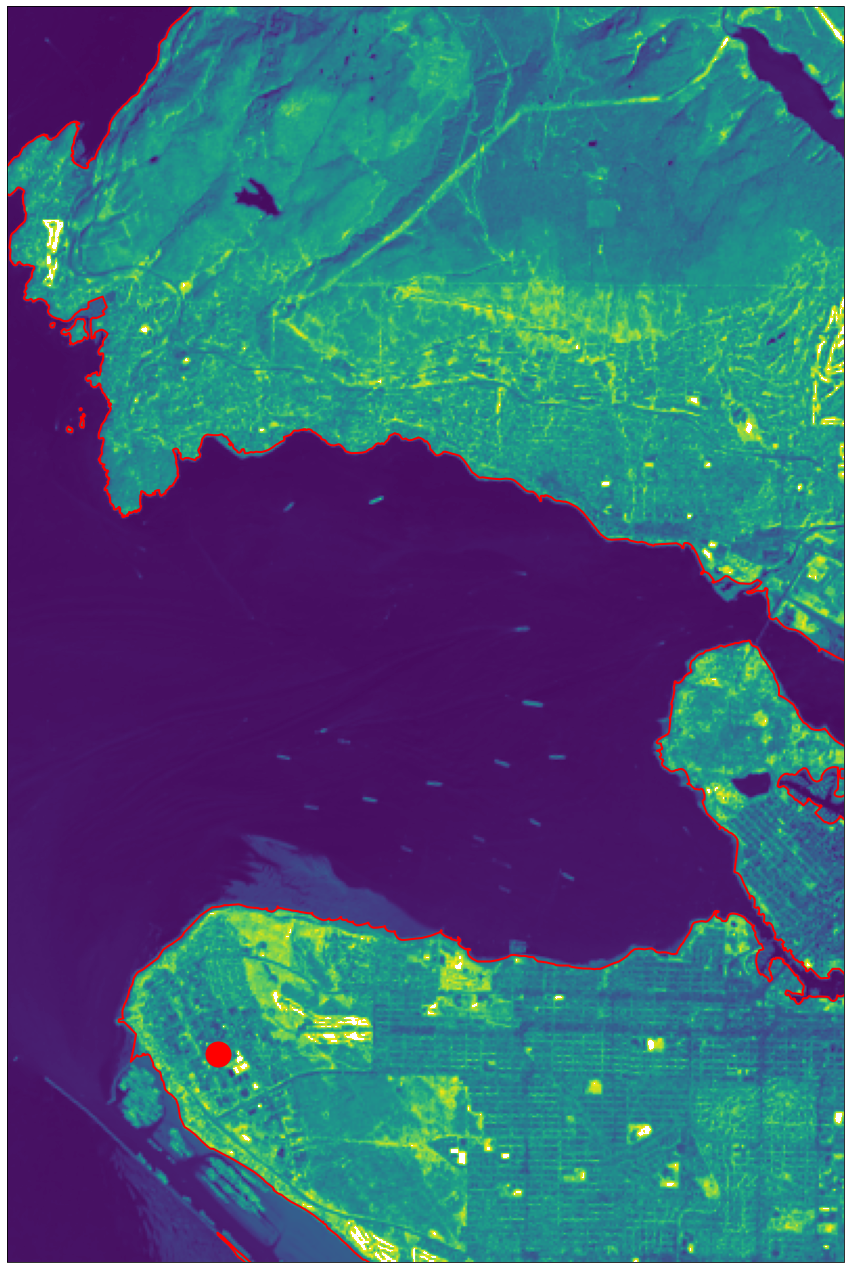

In [13]:
shape_project = cartopy.crs.Geodetic()
ax.add_geometries(
    df_coast["geometry"], shape_project, facecolor="none", edgecolor="red", lw=2
)
display(fig)